How much does pick-order matter?
===

Analyzing pick/draft order by running simulations.

Used for an analysis sent via email.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [167]:
from copy import deepcopy
from itertools import permutations, groupby
from collections import defaultdict
from tqdm import tqdm

In [3]:
contestant_score_dict = {
    'Zac C.': 34,
    'Ben': 20,
    'Ivan': 19,
    'Brendan': 18,
    'Noah': 8,
    'Blake Moynes': 7,
    'Riley': 7,
    'Eazy': 5,
    'Spencer': 4,
    'Bennett': 4,
    'Demar': 4,
    'Ed': 4,
    'Chasen': 2,
    'Joe': 2,
    'Jordan C.': 2,
    'Kenny': 2,
    'Jay': 0,
    'Montel': 0,
    'Peter': 0,
}

In [4]:
df = pd.read_csv('all_rankings.tsv', sep='\t', header=0)
df

,Contestant,Daniel,Sunita,Margo,Greg,Casey,Melanie,Cordelia,Michael,Tim,...,Matt,Kata,Jenna,Emily,Zach,Harini,Katie/Will,Galen,David/Jen,David
0,Ben,9,2,2,3,6,4,13,9,8,...,5,4,4,6,2,1,11,12,17,4
1,Bennett,4,10,5,9,13,13,7,17,11,...,10,5,15,2,7,9,3,13,14,11
2,Blake Moynes,19,14,10,12,3,6,6,11,19,...,18,19,14,4,16,19,18,8,8,17
3,Brendan,2,3,11,1,4,5,2,3,1,...,2,1,3,5,4,3,1,6,9,2
4,Chasen,3,13,15,13,18,18,4,13,14,...,9,8,17,19,14,15,5,15,18,12
5,Demar,13,17,12,18,12,14,16,7,13,...,3,9,11,3,17,10,12,16,5,14
6,Eazy,7,6,3,6,14,7,3,12,4,...,4,10,7,17,9,8,4,2,1,7
7,Ed,17,12,16,17,9,17,11,10,15,...,15,11,10,13,10,16,13,17,19,13
8,Ivan,1,4,9,4,7,10,5,8,3,...,6,2,2,7,1,4,9,7,16,3
9,Jay,10,18,17,14,16,11,14,14,12,...,16,12,13,18,18,12,10,18,15,15


In [5]:
assert len(df) == len(contestant_score_dict)

In [6]:
actual_draft_order = """Daniel
Sunita
Margo
Greg
Casey
Melanie
Cordelia
Michael
Tim
Zoe
Tony
Matt
Kata
Jenna
Emily
Zach
Harini
Katie/Will
Galen
David/Jen
David""".split('\n')
actual_draft_order[:3]

['Daniel', 'Sunita', 'Margo']

In [69]:
def generate_teams(draft_order, contestants, rankings_dict, n_rounds=6, max_teams=7):
    """
    draft_order: a list of participants, in the order they get to draft.
    contestants: list of contestants to include in the draft. Rankings for other contestants are ignored.
    rankings_dict: a map of participant -> list of contestants in the contestants list, sorted by preference. Will be converted to indices...
    """
    participant_draft_list = []
    for i in range(n_rounds):
        participant_draft_list += draft_order if i % 2 == 0 else draft_order[::-1]

    n_contestants = len(contestants)
    remaining_count = np.zeros(n_contestants)
    remaining_count[:] = max_teams
    
    ranking_inds_dict = {}
    for participant, ranked_contestants in rankings_dict.items():
        ranked_contestant_inds = [contestants.index(contestant) for contestant in ranked_contestants]
        ranking_inds_dict[participant] = ranked_contestant_inds
    
    teams_dict = {participant: [] for participant in draft_order}
    for participant in participant_draft_list:
        participant_rankings = ranking_inds_dict[participant]
        is_contestant_chosen = False
        while not is_contestant_chosen:
            desired_contestant_ind = participant_rankings.pop(0)
            if remaining_count[desired_contestant_ind] > 0:
                teams_dict[participant].append(contestants[desired_contestant_ind])
                remaining_count[desired_contestant_ind] -= 1
                is_contestant_chosen = True
    return teams_dict


def generate_rankings_dict(contestants, df):
    participants = list(df.columns)
    participants.remove('Contestant')

    rankings_dict = {}
    df_contestants = list(df.Contestant)
    for participant in participants:
        contestant_ranking = ['' for contestant in contestants]
        for contestant, ranking in zip(df_contestants, df.loc[:,participant]):
            contestant_ranking[ranking-1] = contestant
        rankings_dict[participant] = contestant_ranking
    return rankings_dict


def score_teams(teams_dict, contestant_score_dict):
    scores_dict = {}
    for participant, team in teams_dict.items():
        score = sum([contestant_score_dict[contestant] for contestant in team])
        scores_dict[participant] = score
    return scores_dict


def rank_participants(scores_dict):
    scores = [(score, participant) for participant, score in scores_dict.items()]
    scores.sort(key=lambda tup: tup[0], reverse=True)
    #return {tup[1]: i for i, tup in enumerate(scores)}  # this is a simple approach to ranking that doesn't resolve ties
    ranks_dict = {}
    rank = 0
    for score, group in groupby(scores, key=lambda tup: tup[0]):
        group_size = 0
        for _, participant in group:
            ranks_dict[participant] = rank
            group_size += 1
        rank += group_size
    return ranks_dict
    

In [31]:
contestants = list(contestant_score_dict.keys())
rankings_dict = generate_rankings_dict(contestants, df)
teams_dict = generate_teams(actual_draft_order, contestants, rankings_dict)
teams_dict

{'Daniel': ['Ivan', 'Chasen', 'Bennett', 'Joe', 'Jay', 'Montel'],
 'Sunita': ['Zac C.', 'Ben', 'Ivan', 'Jordan C.', 'Bennett', 'Joe'],
 'Margo': ['Spencer', 'Ben', 'Eazy', 'Joe', 'Bennett', 'Montel'],
 'Greg': ['Brendan', 'Ben', 'Ivan', 'Noah', 'Bennett', 'Chasen'],
 'Casey': ['Spencer', 'Jordan C.', 'Blake Moynes', 'Montel', 'Ed', 'Peter'],
 'Melanie': ['Noah', 'Spencer', 'Ben', 'Blake Moynes', 'Jordan C.', 'Jay'],
 'Cordelia': ['Spencer', 'Brendan', 'Eazy', 'Chasen', 'Blake Moynes', 'Ed'],
 'Michael': ['Zac C.', 'Noah', 'Riley', 'Kenny', 'Demar', 'Ed'],
 'Tim': ['Brendan', 'Ivan', 'Eazy', 'Riley', 'Jordan C.', 'Peter'],
 'Zoe': ['Eazy', 'Jordan C.', 'Jay', 'Kenny', 'Chasen', 'Blake Moynes'],
 'Tony': ['Kenny', 'Ben', 'Demar', 'Riley', 'Peter', 'Montel'],
 'Matt': ['Spencer', 'Brendan', 'Demar', 'Riley', 'Chasen', 'Peter'],
 'Kata': ['Brendan', 'Ivan', 'Bennett', 'Kenny', 'Montel', 'Chasen'],
 'Jenna': ['Zac C.', 'Ivan', 'Riley', 'Noah', 'Ed', 'Jay'],
 'Emily': ['Spencer', 'Bennett', 

In [33]:
scores_dict = score_teams(teams_dict, contestant_score_dict)
rank_participants(scores_dict)

{'Sunita': 0,
 'Harini': 1,
 'Jenna': 2,
 'Greg': 3,
 'David': 4,
 'Katie/Will': 5,
 'David/Jen': 6,
 'Michael': 7,
 'Tim': 8,
 'Zach': 9,
 'Kata': 10,
 'Melanie': 11,
 'Cordelia': 12,
 'Margo': 13,
 'Matt': 14,
 'Tony': 15,
 'Daniel': 16,
 'Galen': 17,
 'Emily': 18,
 'Zoe': 19,
 'Casey': 20}

In [ ]:
# there are 21! ~ 5.1E+19 permutations of length 21

In [27]:
5.1E+19 > 10**19

True

In [72]:
participants = list(df.columns)
participants.remove('Contestant')
contestants = list(contestant_score_dict.keys())
print(f"{len(participants)} participants and {len(contestants)} contestants.")

rankings_dict = generate_rankings_dict(contestants, df)
teams_dict = generate_teams(actual_draft_order, contestants, rankings_dict)
scores_dict = score_teams(teams_dict, contestant_score_dict)
actual_ranks_dict = rank_participants(scores_dict)

simulated_ranks_dict = {participant: [] for participant in participants}

N = 1000000
draft_order = actual_draft_order[:]
for i in tqdm(range(N), total=N):
    np.random.shuffle(draft_order)
    teams_dict = generate_teams(draft_order, contestants, rankings_dict)
    scores_dict = score_teams(teams_dict, contestant_score_dict)
    ranks_dict = rank_participants(scores_dict)
    for participant, rank in ranks_dict.items():
        simulated_ranks_dict[participant].append(rank)
        
    #print(draft_order.index('Zach'))
    #print(teams_dict['Zach'])

  0%|          | 458/1000000 [00:00<08:48, 1889.98it/s]

21 participants and 19 contestants.


100%|██████████| 1000000/1000000 [05:41<00:00, 2925.66it/s]


In [162]:
with open('simulation_results.csv', 'w') as outfile:
    outfile.write("Participant,Actual Rank,Mean Rank,Mean - Actual,Median Rank,Best Rank,Worst Rank,P(rank>actual),P(rank=actual),P(rank<actual),Rank Std\n")
    for participant, actual_rank in actual_ranks_dict.items():
        actual_rank += 1
        ranks = np.array(simulated_ranks_dict[participant])
        ranks += 1
        median_rank = int(np.median(ranks))
        mean_rank = np.mean(ranks)
        rank_std = np.std(ranks)
        best_rank = np.min(ranks)
        worst_rank = np.max(ranks)

        pct_same = np.sum(ranks == actual_rank) / len(ranks)
        pct_better = np.sum(ranks < actual_rank) / len(ranks)
        pct_worse = np.sum(ranks > actual_rank) / len(ranks)

        print(f"{participant:>12} {actual_rank:>3} {median_rank:>3} {mean_rank:>4.1f} {best_rank:>2} - {worst_rank:>2} {pct_worse*100:>4.1f}% {pct_same*100:>4.1f}% {pct_better*100:>4.1f}% {rank_std:.3f}")
        outfile.write(f"{participant},{actual_rank},{mean_rank:.2f},{mean_rank-actual_rank:.2f},{median_rank},{best_rank},{worst_rank},{pct_worse*100:.2f}%,{pct_same*100:.2f}%,{pct_better*100:.2f}%,{rank_std:.4f}\n")
        

      Sunita   1   2  2.1  1 -  6 58.8% 41.2%  0.0% 1.208
      Harini   2   5  5.1  1 - 10 83.4%  6.7%  9.9% 2.534
       Jenna   3   3  2.6  1 -  6 19.3% 32.1% 48.6% 1.116
        Greg   4   4  3.7  1 - 10 33.1% 26.0% 40.8% 1.612
       David   5   3  2.9  1 -  6  1.9% 12.6% 85.5% 1.390
  Katie/Will   6  13 10.8  4 - 18 67.2% 22.6% 10.1% 4.691
   David/Jen   7  13 11.7  4 - 19 62.0% 20.9% 17.1% 4.901
     Michael   8   7  7.4  5 - 10  8.1% 36.5% 55.5% 0.844
         Tim   9   7  6.9  1 - 13 18.8% 18.8% 62.4% 2.770
        Zach  10   9  9.0  7 - 11  2.5% 22.6% 75.0% 0.810
        Kata  11   9  8.5  4 - 13  0.0% 12.2% 87.8% 2.046
     Melanie  12  15 14.7  8 - 19 81.1% 13.8%  5.1% 2.068
    Cordelia  13  13 14.1 10 - 19 49.1% 27.3% 23.6% 2.127
       Margo  14  13 12.8 10 - 17  4.1% 17.6% 78.3% 0.997
        Matt  14  15 15.4 11 - 21 51.5% 26.6% 21.9% 2.454
        Tony  16  15 15.1 11 - 18  9.2% 25.6% 65.2% 1.044
      Daniel  17  11 12.2  8 - 18  6.2% 13.5% 80.3% 3.067
       Galen  

In [166]:
daniel_ranks = np.array(simulated_ranks_dict['Daniel'])
daniel_ranks += 1
tony_ranks = np.array(simulated_ranks_dict['Tony'])
tony_ranks += 1
np.sum(daniel_ranks < tony_ranks) / len(daniel_ranks)

0.718719

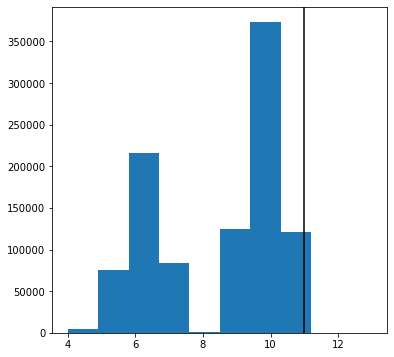

In [111]:
participant = 'Kata'
ranks = simulated_ranks_dict[participant]
ranks = np.array(ranks)
ranks += 1

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.hist(ranks, bins=len(set(ranks)))
ax.axvline(actual_ranks_dict[participant] + 1, color='black')

plt.show()

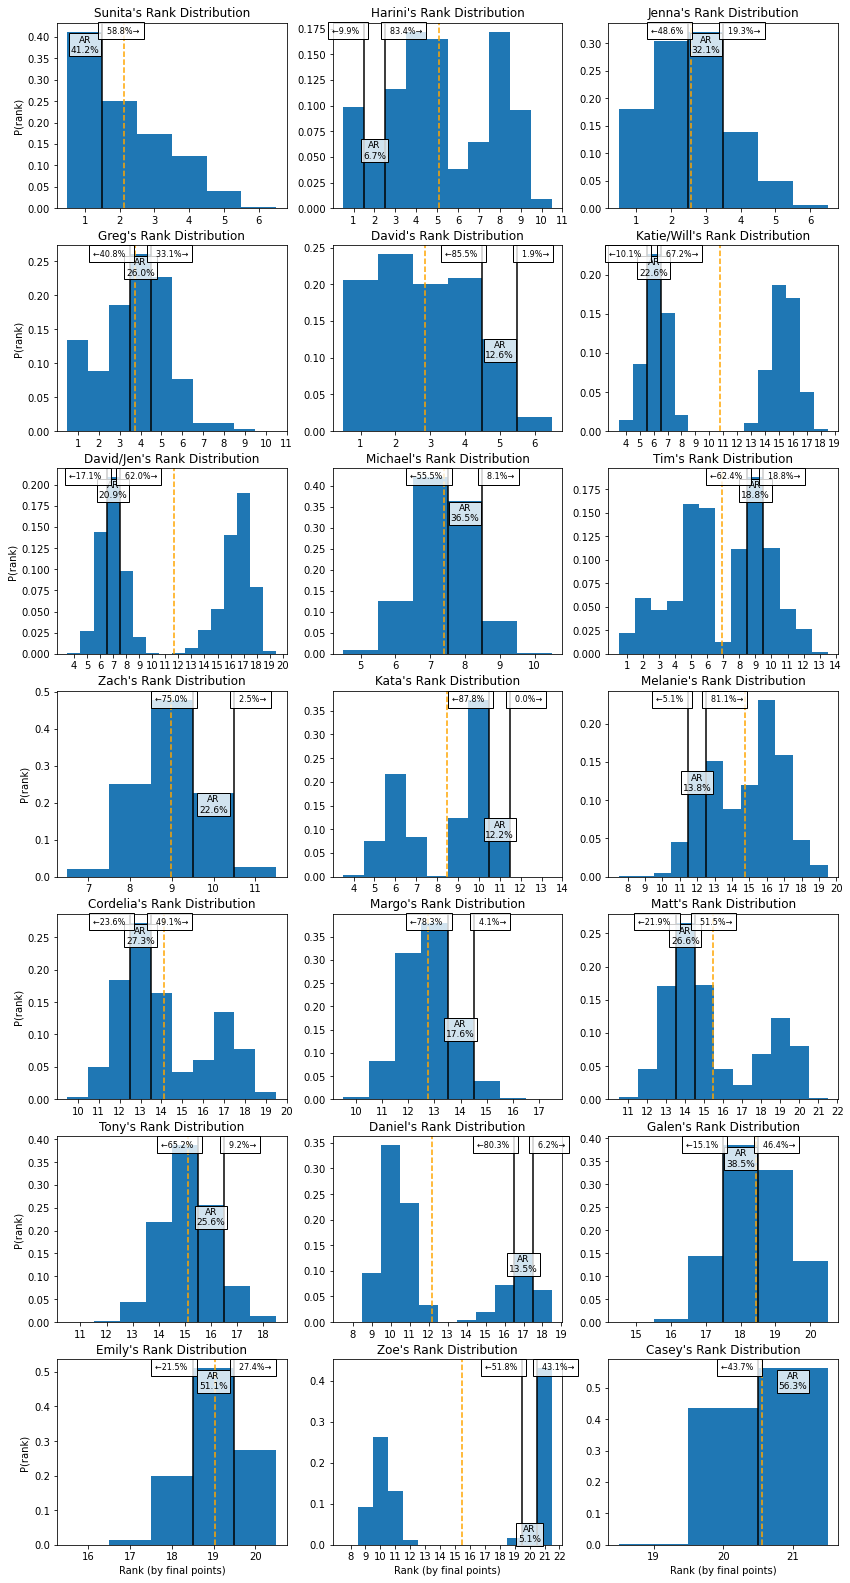

In [159]:
fig, axes = plt.subplots(7, 3, figsize=(14, 28))
axes = np.reshape(axes, (-1,))

participants = list(actual_ranks_dict.keys())

i = 0
for participant, ax in zip(participants, axes):
    ranks = simulated_ranks_dict[participant]
    ranks = np.array(ranks)
    ranks += 1
    
    bins = np.arange(np.min(ranks), np.max(ranks) + 2)
    ax.set_xticks(bins)
    
    ax.hist(ranks, bins=bins, density=True, align='left')
    ar = actual_ranks_dict[participant] + 1  # get actual rank
    
    mr = np.mean(ranks)
    
    pct_same = np.sum(ranks == ar) / len(ranks)
    pct_better = np.sum(ranks < ar) / len(ranks)
    pct_worse = np.sum(ranks > ar) / len(ranks)
    
    ax.text(ar, pct_same * 0.98, f'AR\n{pct_same*100:.1f}%',
           ha='center', va='top', 
            bbox=dict(facecolor=(1, 1, 1, 0.8), edgecolor='black', boxstyle='square,pad=0.2'),
            #backgroundcolor=(1, 1, 1, 0.8), 
            fontsize=9)
    
    if ar > 1:
        ax.axvline(ar-0.5, color='black', linestyle='-')
        ax.text(ar-0.5, ax.get_ylim()[1] * 0.98, f'←{pct_better*100:.1f}%  ',
            ha='right', va='top',
                bbox=dict(facecolor=(1, 1, 1, 0.8), edgecolor='black'),
            fontsize=8)
        
    if ar < 21:
        ax.axvline(ar+0.5, color='black', linestyle='-')
        ax.text(ar+0.5, ax.get_ylim()[1] * 0.98, f'  {pct_worse*100:.1f}%→',
            ha='left', va='top',
                bbox=dict(facecolor=(1, 1, 1, 0.8), edgecolor='black'),
            fontsize=8)
        
    # plot the mean rank
    ax.axvline(mr, color='orange', linestyle='--')
    
    ax.set_title(f"{participant}'s Rank Distribution")
    if i % 3 == 0:
        ax.set_ylabel("P(rank)")
    if i >= 18:
        ax.set_xlabel("Rank (by final points)")
    
    
    i += 1

plt.show()

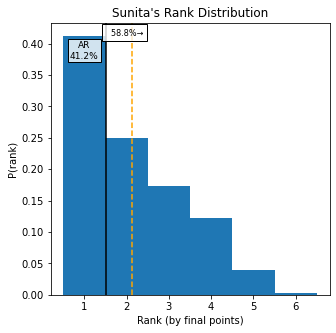

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
participant = "Sunita"

ranks = simulated_ranks_dict[participant]
ranks = np.array(ranks)
ranks += 1

bins = np.arange(np.min(ranks), np.max(ranks) + 2)
ax.set_xticks(bins)

ax.hist(ranks, bins=bins, density=True, align='left')
ar = actual_ranks_dict[participant] + 1  # get actual rank

mr = np.mean(ranks)

pct_same = np.sum(ranks == ar) / len(ranks)
pct_better = np.sum(ranks < ar) / len(ranks)
pct_worse = np.sum(ranks > ar) / len(ranks)

ax.text(ar, pct_same * 0.98, f'AR\n{pct_same*100:.1f}%',
       ha='center', va='top', 
        bbox=dict(facecolor=(1, 1, 1, 0.8), edgecolor='black', boxstyle='square,pad=0.2'),
        #backgroundcolor=(1, 1, 1, 0.8), 
        fontsize=9)

if ar > 1:
    ax.axvline(ar-0.5, color='black', linestyle='-')
    ax.text(ar-0.5, ax.get_ylim()[1] * 0.98, f'←{pct_better*100:.1f}%  ',
        ha='right', va='top',
            bbox=dict(facecolor=(1, 1, 1, 0.8), edgecolor='black'),
        fontsize=8)

if ar < 21:
    ax.axvline(ar+0.5, color='black', linestyle='-')
    ax.text(ar+0.5, ax.get_ylim()[1] * 0.98, f'  {pct_worse*100:.1f}%→',
        ha='left', va='top',
            bbox=dict(facecolor=(1, 1, 1, 0.8), edgecolor='black'),
        fontsize=8)

# plot the mean rank
ax.axvline(mr, color='orange', linestyle='--')

ax.set_title(f"{participant}'s Rank Distribution")
ax.set_ylabel("P(rank)")
ax.set_xlabel("Rank (by final points)")

plt.show()

In [213]:
participants = list(df.columns)
participants.remove('Contestant')
contestants = list(contestant_score_dict.keys())

rankings_dict = generate_rankings_dict(contestants, df)
teams_dict = generate_teams(actual_draft_order, contestants, rankings_dict)
scores_dict = score_teams(teams_dict, contestant_score_dict)
actual_ranks_dict = rank_participants(scores_dict)

simulated_ranks_dict = {participant: [] for participant in participants}

target_participant = 'Harini'
bimodal_split = 5  # the rank between the two modes
better_team_feats = defaultdict(list)
better_order_feats = defaultdict(list)
worse_team_feats = defaultdict(list)
worse_order_feats = defaultdict(list)

N = 100000
draft_order = actual_draft_order[:]
for i in tqdm(range(N), total=N):
    np.random.shuffle(draft_order)
    teams_dict = generate_teams(draft_order, contestants, rankings_dict)
    scores_dict = score_teams(teams_dict, contestant_score_dict)
    ranks_dict = rank_participants(scores_dict)
    for participant, rank in ranks_dict.items():
        simulated_ranks_dict[participant].append(rank)
    
    team = teams_dict[target_participant]
    team_feats = {contestant + '_on_team': contestant in team for contestant in contestants}
    
    rank = ranks_dict[target_participant]
    
    order = draft_order.index(target_participant)
    order_feats = {participant + '_drafted_first': draft_order.index(participant) < order for participant in participants}
    order_feats['order'] = order
    
    if rank > bimodal_split:  # ranked worse
        for key, value in team_feats.items():
            worse_team_feats[key].append(value)
        for key, value in order_feats.items():
            worse_order_feats[key].append(value)
    elif rank < bimodal_split:   # ranked better
        for key, value in team_feats.items():
            better_team_feats[key].append(value)
        for key, value in order_feats.items():
            better_order_feats[key].append(value)
        
        


100%|██████████| 100000/100000 [00:35<00:00, 2794.96it/s]


In [214]:
for feat, values in worse_team_feats.items():
    pct_worse = np.sum(worse_team_feats[feat]) / len(worse_team_feats[feat]) if len(worse_team_feats[feat]) > 0 else 0
    pct_better = np.sum(better_team_feats[feat]) / len(better_team_feats[feat]) if len(better_team_feats[feat]) else 0
    diff = pct_better - pct_worse
    if pct_worse - pct_better != 0:
        print(f"{feat:>18} {pct_better*100:>5.2f}% {pct_worse*100:>5.2f}% {'+' if diff > 0 else ''}{diff*100:.2f}%")
print()

for feat, values in worse_order_feats.items():
    pct_worse = np.sum(worse_order_feats[feat]) / len(worse_order_feats[feat]) if len(worse_order_feats[feat]) > 0 else 0
    pct_better = np.sum(better_order_feats[feat]) / len(better_order_feats[feat]) if len(better_order_feats[feat]) else 0
    diff = pct_better - pct_worse
    if pct_worse - pct_better != 0:
        print(f"{feat:>18} {pct_better*100:>5.2f}% {pct_worse*100:>5.2f}% {'+' if diff > 0 else ''}{diff*100:.2f}%")
print()

    Zac C._on_team 79.19%  0.00% +79.19%
      Ivan_on_team 44.36% 90.07% -45.71%
   Brendan_on_team 19.90%  9.93% +9.97%
      Noah_on_team 97.37% 100.00% -2.63%
     Riley_on_team 58.40% 31.66% +26.74%
   Bennett_on_team 36.08% 89.07% -53.00%
     Demar_on_team 84.68% 81.41% +3.27%
       Jay_on_team 80.02% 97.86% -17.84%

Daniel_drafted_first 69.43% 15.71% +53.72%
Sunita_drafted_first 63.61% 26.88% +36.73%
Margo_drafted_first 65.58% 21.76% +43.82%
Greg_drafted_first 67.79% 19.60% +48.19%
Casey_drafted_first 65.62% 22.88% +42.74%
Melanie_drafted_first 65.51% 22.29% +43.21%
Cordelia_drafted_first 69.06% 16.27% +52.79%
Michael_drafted_first 65.34% 22.87% +42.47%
 Tim_drafted_first 68.39% 18.47% +49.91%
 Zoe_drafted_first 69.04% 15.42% +53.62%
Tony_drafted_first 65.50% 21.34% +44.16%
Matt_drafted_first 68.96% 15.94% +53.02%
Kata_drafted_first 65.30% 23.72% +41.58%
Jenna_drafted_first 66.19% 20.88% +45.31%
Emily_drafted_first 65.31% 22.33% +42.97%
Zach_drafted_first 65.01% 23.68% +41.34%

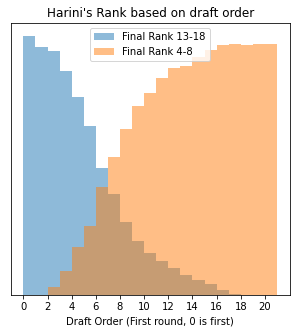

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

bins = np.arange(0, 22)
ax.hist(worse_order_feats['order'], bins=bins, alpha=0.5, label='Final Rank 13-18')
ax.hist(better_order_feats['order'], bins=bins, alpha=0.5, label='Final Rank 4-8')

ax.legend()
ax.set_xlabel('Draft Order (First round, 0 is first)')
ax.set_yticks([])
ax.set_xticks(np.arange(0, 22, 2))
ax.set_title(f"{target_participant}'s Rank based on draft order")

plt.show()